In [1]:
!pip install pandas natasha pymystem3 ipymarkup nltk matplotlib seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 61.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=0ee720e094c670ea2b54f7043adcfdd9fb04124aeaecd36be16516611e1a87e0
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9acf629a8ec4d5ff08437ed50f180a3cc50032972fc452730a232e513b7cbaf8
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built intervaltree docopt


In [2]:
import pandas as pd
import pymystem3
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)
from ipymarkup import show_dep_ascii_markup as show_markup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Загружаем данные
df = pd.read_csv('statyi.csv', sep='\t')

# Удаляем лишние столбцы
morph_df = df.drop(["Unnamed: 0", "created_date"], axis=1)
morph_df

,title,content,category
0,Климкин рассказал о главных достижениях Украин...,Министр иностранных дел Украины Павел Климкин ...,Бывший СССР
1,В России запретили алкогольные энергетики,В России с 1 января 2018 года запрещаются прои...,Россия
2,Полиция Берлина сообщила о случаях сексуальных...,Полиция Берлина заявила об имевших место сексу...,Мир
3,МЧС отчиталось о первых часах наступившего года,Чрезвычайных ситуаций во время время празднова...,Россия
4,Обнаружено неожиданное средство от старения мозга,Ученые Ланкастерского университета в Великобри...,Наука и техника
...,...,...,...
9995,Стали известны сроки появления российской базы...,Российскую базу на Луне планируется развернуть...,Наука и техника
9996,На Аляске произошло мощное землетрясение,"Землетрясение магнитудой 7,0 произошло в пятни...",Мир
9997,Названо главное блюдо мировых лидеров на самми...,Главным блюдом на ужине в первый день саммита ...,Мир
9998,Анджелина Джоли и Брэд Питт договорились об оп...,Голливудские актеры Анджелина Джоли и Брэд Пит...,Из жизни


# Анализ данных

## Токенизация и лемматизация слов

### Токенизация

In [5]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

#Хранилище токенов к каждому предложению
sent_tokens = []

for article in morph_df['content']:
    doc = Doc(article)
    doc.segment(segmenter)
    doc.parse_syntax(syntax_parser)
    doc.tag_morph(morph_tagger)
    for sentence in doc.sents: # получаем предложения
        # При принте синтаксиса вылетает ошибка "max() iterable argument is empty"
        #sentence.syntax.print()
        sent_tokens.append([])
        for token in sentence.tokens: # получаем токены
            #print(token)
            sent_tokens[-1].append(token)



### Лемматизация

In [6]:
mystem=pymystem3.Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [7]:

lemma = []

for x in range(len(sent_tokens)):
    lemma.append([])
    for y in range(len(sent_tokens[x])):
        lemma[-1].append(mystem.lemmatize(sent_tokens[x][y].text))

In [8]:
lemma[0]

[['министр', '\n'],
 ['иностранный', '\n'],
 ['дело', '\n'],
 ['украина', '\n'],
 ['павел', '\n'],
 ['климкин', '\n'],
 ['записывать', '\n'],
 ['видеообращение', '\n'],
 [',\n'],
 ['в', '\n'],
 ['который', '\n'],
 ['перечислять', '\n'],
 ['главный', '\n'],
 ['достижение', '\n'],
 ['украина', '\n'],
 ['в', '\n'],
 ['2017', '\n'],
 ['год', '\n'],
 ['.', '\n']]

## Наиболее встречающиеся пары подлежащих и сказуемых

In [9]:
#Составляем датафрейм с парами
words_pairs = []
for sentance in sent_tokens:
    words_pairs.append([None, None])
    for word in sentance:
        word_role = -1
        match word.rel:
            case 'nsubj':
                word_role = 0
            case 'root':
                word_role = 1
            case _:
                pass
        if word_role > -1:
            if words_pairs[-1][word_role] != None:
                    words_pairs.append([None, None])
            words_pairs[-1][word_role] = mystem.lemmatize(word.text)[0]


words_dict = {
    'pair': [],
    'popularity': []
}

for pair in words_pairs:
  if pair[0] != None:
    if pair[1] != None:
       cur_pair = pair[0]+"_"+pair[1]
       #words_dict['pair'].append(pair[0]+"_"+pair[1])
       if cur_pair not in words_dict['pair']:
          words_dict['pair'].append(cur_pair)
          words_dict['popularity'].append(1)
       else:
          words_dict['popularity'][words_dict['pair'].index(cur_pair)] += 1

words_df = pd.DataFrame(words_dict)

words_df

,pair,popularity
0,министр_записывать,1
1,видео_доступно,13
2,он_причислять,2
3,он_отмечать,257
4,это_год,2
...,...,...
53784,ссора_сообщаться,1
53785,россиянин_отапливать,1
53786,площадь_становиться,1
53787,издание_высказывать,1


In [10]:
words_df.sort_values(by=['popularity'], ascending=False)

,pair,popularity
210,The_сообщать,404
675,издание_сообщать,402
14,риа_сообщать,292
372,инцидент_происходить,264
3,он_отмечать,257
...,...,...
21907,это_настораживать,1
21908,писательница_объехать,1
21909,иносми_сообщать,1
21910,фатланд_проехать,1


In [11]:
#Выводим топ 10 самых популярным парам
stat_df = words_df.sort_values(by=['popularity'], ascending=False).head(10)
stat_df

,pair,popularity
210,The_сообщать,404
675,издание_сообщать,402
14,риа_сообщать,292
372,инцидент_происходить,264
3,он_отмечать,257
936,он_рассказывать,202
940,он_заявлять,198
254,агентство_сообщать,195
44,человек_погибать,187
97,тасс_сообщать,182


Исходя из топа по данным с новостного сайта можно сделать вывод о большом количестве использования новостей с "РИА Новости". Также, сайт немного ссылался на ТАСС.

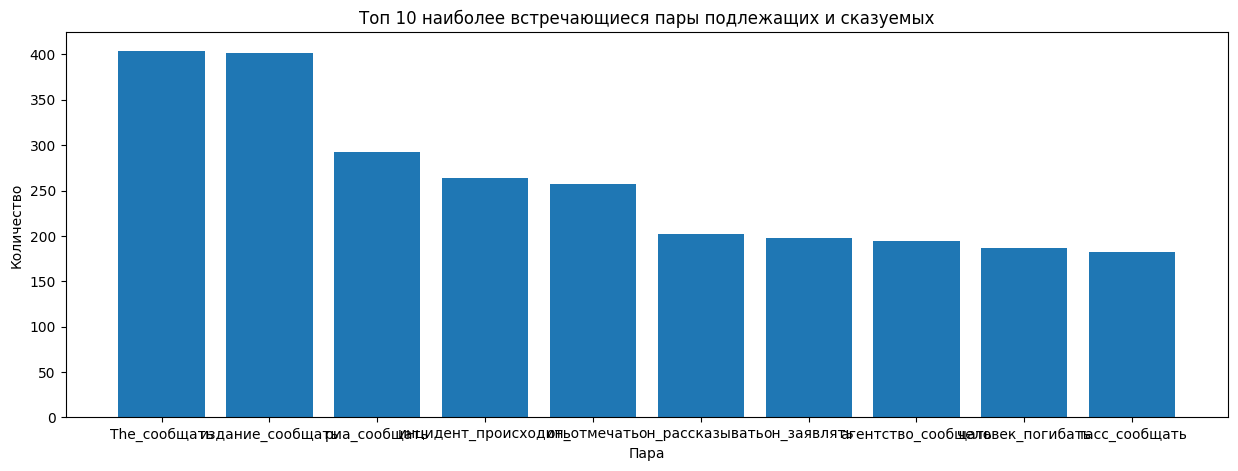

In [12]:
#Гистограмма

plt.figure(figsize=(15, 5))
plt.bar(stat_df['pair'], stat_df['popularity'])
#sns.histplot(stat_df['popularity'], bins=6, edgecolor='black')
plt.title('Топ 10 наиболее встречающиеся пары подлежащих и сказуемых')
plt.xlabel('Пара')
plt.ylabel('Количество')
plt.show()

### Популярные слова

In [13]:
#Чистим датасет от ненужных данных

nltk.download(['averaged_perceptron_tagger_ru', 'stopwords', 'punkt'])

STOP_LIST = nltk.corpus.stopwords.words('russian')

punkt_list = [".", ",", "!", "?", "...", ":", ";"]

for simb in punkt_list:
  STOP_LIST.append(simb)

lemma_words = {
    'word' : []
}

for sent in lemma:
  for word in sent:
    if word[0] not in STOP_LIST:
      #убираем числа
      try:
        if isinstance(int(word[0]), int):
          pass
      except ValueError:
          lemma_words['word'].append(word[0])

lemma_df = pd.DataFrame(lemma_words)

lemma_df

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,word
0,министр
1,иностранный
2,дело
3,украина
4,павел
...,...
1404216,суэцкий
1404217,канал
1404218,северный
1404219,морской


In [14]:
# Высчитываем популярные слова
vectorizer = TfidfVectorizer()
# Беру первые 100к, т.к. все ~2.5 ляма слов просто не помещаются в оперативу
X = vectorizer.fit_transform(lemma_df['word'].head(100000))

word_pop_count = pd.DataFrame(X.toarray()).sum(axis = 0)


df_pop_words = pd.DataFrame({'word': vectorizer.get_feature_names_out(),
                            'popularity': word_pop_count})

#Топ 10 популярных слов
pw = df_pop_words.sort_values(by=['popularity'], ascending=False).head(10)
pw

,word,popularity
13885,это,1112.0
3180,год,1069.0
5616,который,718.0
11538,сообщать,485.0
13967,январь,452.0
10670,россия,418.0
10958,свой,382.0
12107,также,347.0
13439,человек,331.0
2735,время,300.0


Исходя из топа, можно сделать вывод по данным с новостного сайта, что было много событий у России в январе.

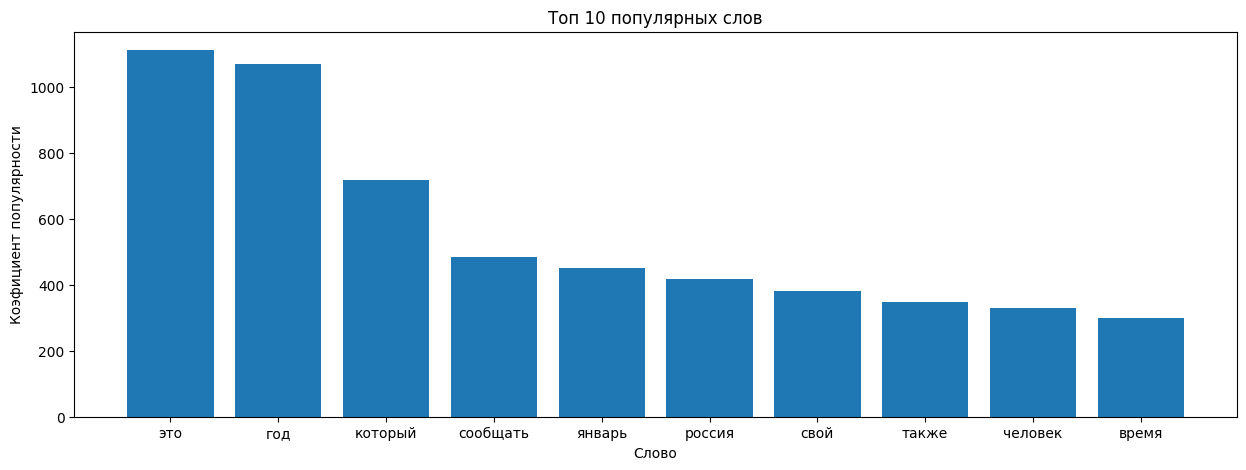

In [15]:
#Гистограмма

plt.figure(figsize=(15, 5))
plt.bar(pw['word'], pw['popularity'])
#sns.histplot(stat_df['popularity'], bins=6, edgecolor='black')
plt.title('Топ 10 популярных слов')
plt.xlabel('Слово')
plt.ylabel('Коэфициент популярности')
plt.show()